In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import ccxt

In [3]:
def load_crypto_batch(since,timeframe,symbols):
    bnc = ccxt.binance()
    dataframes = []
    labels = []
    for coin in symbols:
        pair = "".join([coin,"/USDT"])
        try:
            dataframes.append(pd.DataFrame(bnc.fetch_ohlcv(pair,limit=1000,since=since,timeframe=timeframe),columns=["timestamp","open","high","low","close","volume"]).set_index("timestamp"))
            labels.append(str(coin))
        except:
            print("Binance does not have", coin)
    opens = pd.DataFrame(dataframes[0].open).rename(columns={'open':labels[0]})
    Volumes = pd.DataFrame(dataframes[0].volume).rename(columns={'Volume':labels[0]})
    for i,coin in enumerate(labels[1:]):
        temp_opens = pd.DataFrame(dataframes[i+1].open).rename(columns={'open':coin})
        temp_volumes = pd.DataFrame(dataframes[i+1].Volume).rename(columns={'Volume':coin})
        opens = opens.merge(temp_opens,how='outer',on='timestamp')
        Volumes = Volumes.merge(temp_volumes,how='outer',on='timestamp')
    return (opens,Volumes)

def load_crypto(days=1000,timeframe='1h',n=30):
    bnc = ccxt.binance()
    symbols = ['BTC']#,'ETH','BNB','SOL','ADA','XRP','DOT','DOGE','SHIB','LUNA','AVAX','UNI','LINK','LTC','MATIC','ALGO','BCH','VET','AXS','XLM','ATOM','ICP','FIL','THETA','TRX']
    n = min(len(symbols),n)
    symbols = symbols[:n]
    since = bnc.milliseconds () - 86400000*days  # -1*days day from now
    all_orders = []
    all_volumes = []
    while since <= (bnc.milliseconds()-2000*60*60):
        limit = 1000  # change for your limit
        orders,volumes = load_crypto_batch(since,timeframe,symbols)
        since = int(orders.index[-1])
        all_orders.append(orders)
        all_volumes.append(volumes)
        print(bnc.milliseconds()/1000,since/1000)
    combined = pd.concat(all_orders)
    combined_vols = pd.concat(all_volumes)
    return combined,combined_vols
    
#gets a dataframe of prices, returns a dataframe of returns
def get_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        returns[i] = price_arr[i,:]/price_arr[i-1,:]
    returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(returns_df)

#gets a dataframe of prices, returns a dataframe of the log returns
def get_log_returns(prices: object) -> object:
    price_arr = np.asarray(prices)
    time_arr = np.asarray(prices.index)
    columns = np.asarray(prices.columns)
    log_returns = np.zeros([len(time_arr)-1,len(columns)])
    for i,val in enumerate(time_arr[1:]):
        log_returns[i] = np.log(price_arr[i,:]/price_arr[i-1,:])
    log_returns_df = pd.DataFrame(returns,index=time_arr[1:], columns=columns)
    return pd.DataFrame(log_returns_df)

In [29]:
BTC = pd.concat([volumes],axis=1).reset_index()
BTC.dtypes
BTC['timestamp'] = BTC['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x/1000)))
BTC = BTC.set_index("timestamp").resample('D').sum()

In [6]:
crypto_data = pd.read_csv("https://raw.githubusercontent.com/louis-stp/CryptoPortfolio/main/CryptoPrices")
crypto_data['timestamp'] = crypto_data['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x/1000)))
crypto_data.set_index("timestamp", inplace=True)
crypto_data = crypto_data.loc[:,crypto_data.columns[crypto_data.isna().sum(axis=0)<15000]]
nona = crypto_data.dropna().pct_change()[1:]

In [ ]:
regressor = 'BTC'
tickers = list(set(training.columns)-set([regressor]))

In [ ]:
X = np.array(nona[regressor]).reshape(-1,1)
y = np.array(nona[tickers]).reshape(-1,len(tickers)) #second number is the number of stocks I think

In [ ]:
#use all data as training data because we arn't predicting anything
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [ ]:
coins = {k: [] for k in tickers}
for n in range(len(tickers)):
    lm.fit(X,y[:,n])
    coins[tickers[n]].append(lm.coef_[0])
    coins[tickers[n]].append(lm.score(X,y[:,n]))
    coins[tickers[n]].append(lm.intercept_)

In [ ]:
pd.DataFrame(coins, index = ['BTC Beta','R^2','Alpha']).T

form mean-variance optimized

In [ ]:
#should really resample to daily data
t = 12*30*24 #number to makes std and means equivelent to yearly returns so 12 for monthly, 52 for weekly and 252 for daily
posLB = -.1  #lower bound on position exposure
posUB = .5  #upper bound on position exposure

muf = pd.Series(0)
returns = training
mean_vect = training.mean() * t

In [ ]:
from scipy.optimize import linprog
m = len(training.columns)
#set equality constraints. I want my positions to sum to 1
A_eq = np.array((1,)*m).reshape(1,-1)
b_eq = [1]

# set bounds on leverage. We can short but we can not go long
bounds = np.vstack([(posLB,)*m,(posUB,)*m]).T

In [ ]:
table_min = linprog(c=mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds)
min_rtn = mean_vect @ table_min.x
table_max = linprog(c=-mean_vect, A_eq = A_eq, b_eq = b_eq, bounds=bounds)
max_rtn = mean_vect @ table_max.x

In [ ]:
from qpsolvers import solve_qp
muP = np.arange(min_rtn * .995,max_rtn * .995, .001)
sdP = np.zeros(len(muP))
weights = np.zeros([len(muP),m])

Cov = 2*np.array(returns.cov())
q_vec = np.zeros(m).reshape(-1,)
G = np.zeros([m,m])
h = np.zeros(m)
A = np.vstack([np.array((1,)*m).reshape(1,-1),mean_vect])

In [ ]:
for i in range(len(muP)):
    b = np.array([1,muP[i]])
    weights[i] = solve_qp(P=Cov, q = q_vec, G=G, h=h, A=A, b=b, lb = bounds[:,0], ub = bounds[:,1])
    sdP[i] = np.sqrt(weights[i] @ (Cov/2) @ weights[i]) * np.sqrt(t)

In [ ]:
portfolios = pd.DataFrame({'Returns': muP, 'Volatility': sdP,})

for counter, symbol in enumerate(tickers):
    #print(counter, symbol)
    portfolios[symbol+' weight'] = [w[counter] for w in weights]
    
portfolios['Sharpe'] = (portfolios['Returns']-muf.values) / portfolios['Volatility'] #note using monthly returns and vol

In [ ]:
tangent = portfolios.iloc[[portfolios.Sharpe.argmax()]]
min_var = portfolios.iloc[[portfolios.Volatility.argmin()]]
efficient_portfolios = portfolios[portfolios['Returns'] >= min_var.Returns.values[0]-.02] #the .02 is arbitrary to see a bit below the min var port too

In [ ]:
efficient_portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=5, alpha=0.7, grid=True, figsize=[7,5], xlim = (0,2))
plt.scatter(0,muf, marker = '.',s=500, c = 'k')
plt.scatter(tangent.Volatility,tangent.Returns, marker = '.',s=300,c='g')
x = np.arange(0,2,.01)
plt.plot(x,tangent.Sharpe.values[0]*x+muf.values[0],c='m')

In [ ]:
#https://pyportfolioopt.readthedocs.io/en/latest/

In [ ]:
def correlation(dataset,SandP,day):
    return dataset.loc[day[0]:day[1]].corr()[SandP][1:]
days = training.resample('W-MON').mean().index
corrs_mat = np.zeros([len(days),len(tickers)])
for n in range(len(days)-1):
    corrs_mat[n,:] = correlation(training,'BTC',days.astype(str)[n:n+2]).values
pd.DataFrame(corrs_mat,index=days,columns = tickers).plot(figsize=[8,6])
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

The real stuff

In [8]:
from pandas_datareader import data, wb
#SPY_data = pd.read_csv("spy.xlsx", encoding = 'unicode_escape')
SPY_data = pd.read_excel("spy.xlsx") 
SPY_vol = data.DataReader(['SPY'], 'yahoo', crypto_data.index[0], crypto_data.index[-1])[['Adj Close','Volume']].swaplevel(axis=1)['SPY']

In [9]:
SPY_data = (SPY_data
 .rename(columns=SPY_data.iloc[2])
 .iloc[3:1000,:3]
 .set_index('Date')
 .drop('NAV',axis=1)
 .loc["04-Nov-2021":"11-Feb-2019",:]
)

In [10]:
SPY_data.index = SPY_vol.index

In [59]:
SPY = (SPY_data
 .join(SPY_vol)
 .astype(float)
      )
SPY = (SPY
 .assign(vol_norm = SPY['Volume'] / SPY['Shares Outstanding'])
 .assign(SPYreturn = SPY["Adj Close"].pct_change())

)[1:]

In [63]:
SPY = SPY.loc[:,:]

In [71]:
SPY

,Shares Outstanding,Adj Close,Volume,vol_norm,SPYreturn
Date,,,,,
2019-02-19,906232116.0,265.094238,59120800.0,0.065238,0.001731
2019-02-20,907032116.0,265.628540,76610800.0,0.084463,0.002016
2019-02-21,902332116.0,264.683960,64214700.0,0.071165,-0.003556
2019-02-22,898482116.0,266.325012,78114600.0,0.086941,0.006200
2019-02-25,903382116.0,266.687561,69030700.0,0.076414,0.001361
...,...,...,...,...,...
2021-10-29,926332116.0,459.250000,70108200.0,0.075684,0.002029
2021-11-01,934432116.0,460.040009,48433600.0,0.051832,0.001720
2021-11-02,933482116.0,461.899994,48908400.0,0.052394,0.004043


<AxesSubplot:xlabel='Date'>

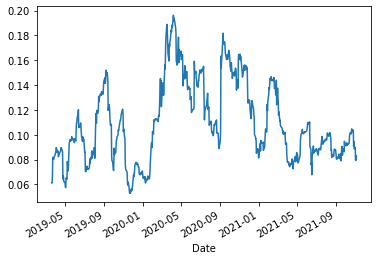

In [13]:
(SPY.SPYreturn.rolling(21).std()/SPY['vol_norm'].rolling(21).mean()).plot()

In [ ]:
#https://www.blockchain.com/charts/total-bitcoins
#bitcoins supply increases approximately linearly

In [ ]:
#diff between two dates
a = datetime.strptime("2019-02-18", "%Y-%m-%d")
b = datetime.strptime("2020-05-11", "%Y-%m-%d")
(b-a).days

In [30]:
def BTC_total_coins(x):
    if x < 448:
        return (18.375-17.545)*10**6/448 * x + (17.545 * 1 * 10 ** 6)
    else:
        return (18.773-18.375)*10**6/447 * (x-447) + (18.375 * 1 * 10 ** 6)
    
x = np.arange(990)
y = []

for i in x:
    y.append(BTC_total_coins(i))

In [31]:
BTC_usable = BTC.loc["2019-02-19":"2021-11-04"]

In [32]:
y = pd.Series(y,index=BTC_usable.index)

In [33]:
BTC_usable['coin_supply'] = y

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [34]:
BTC_usable['vol_norm'] = BTC_usable["volume"]/BTC_usable["coin_supply"]

In [35]:
BTC_usable

,volume,coin_supply,vol_norm
timestamp,,,
2019-02-19,22312.446914,1.754500e+07,0.001272
2019-02-20,34469.665463,1.754685e+07,0.001964
2019-02-21,31390.659592,1.754871e+07,0.001789
2019-02-22,21907.760497,1.755056e+07,0.001248
2019-02-23,38232.879917,1.755241e+07,0.002178
...,...,...,...
2021-10-31,40817.013010,1.885402e+07,0.002165
2021-11-01,41701.329110,1.885491e+07,0.002212
2021-11-02,46006.735570,1.885581e+07,0.002440


In [36]:
BTC_price = pd.concat([prices],axis=1).reset_index()
BTC_price['timestamp'] = BTC_price['timestamp'].apply(lambda x: datetime.fromtimestamp(int(x/1000)))
BTC_price = BTC_price.set_index("timestamp").resample('D').last()
BTC_usable['Price'] = BTC_price

In [43]:
BTC_usable['BTC_returns'] = BTC_usable['Price'].pct_change()

/opt/homebrew/Caskroom/miniforge/base/envs/tfenv/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [44]:
BTC_usable.head()

,volume,coin_supply,vol_norm,Price,BTC_returns
timestamp,,,,,
2019-02-19,22312.446914,1.754500e+07,0.001272,3912.11,NaN
2019-02-20,34469.665463,1.754685e+07,0.001964,3968.05,0.014299
2019-02-21,31390.659592,1.754871e+07,0.001789,3953.03,-0.003785
2019-02-22,21907.760497,1.755056e+07,0.001248,3969.80,0.004242
2019-02-23,38232.879917,1.755241e+07,0.002178,4170.63,0.050589


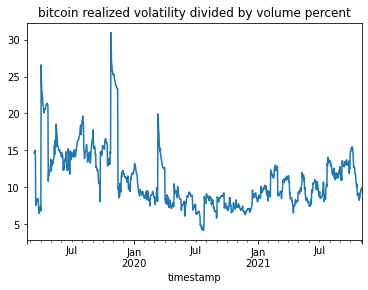

In [51]:
(BTC_usable['BTC_returns'].rolling(21).std()/BTC_usable['vol_norm'].rolling(21).mean()).plot()
plt.title("bitcoin realized volatility divided by volume percent")
plt.show()

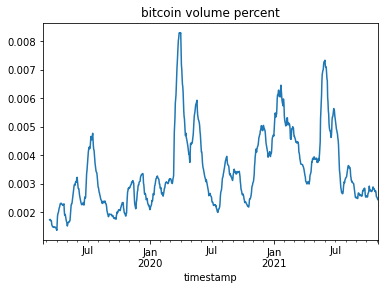

In [53]:
BTC_usable['vol_norm'].rolling(21).mean().plot()
plt.title("bitcoin volume percent")
plt.show()

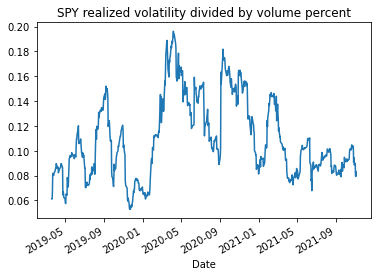

In [52]:
(SPY.SPYreturn.rolling(21).std()/SPY['vol_norm'].rolling(21).mean()).plot()
plt.title("SPY realized volatility divided by volume percent")
plt.show()

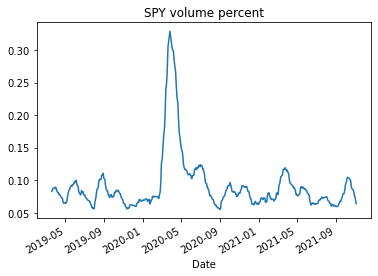

In [54]:
SPY['vol_norm'].rolling(21).mean().plot()
plt.title("SPY volume percent")
plt.show()